#**Análisis de una pandemia: Coronavirus**



> Juan José Arango Serrano - 2161069

>Omar Sánchez Arciniegas - 2161636

>Andrés Felipe Gómez Ortiz - 2161073









>De la Organización Mundial de la Salud: el 31 de diciembre de 2019, la OMS recibió una alerta sobre varios casos de neumonía en la ciudad de Wuhan, provincia de Hubei en China. El virus no coincidía con ningún otro virus conocido. Esto generó preocupación porque cuando un virus es nuevo, no sabemos cómo afecta a las personas.

##**Objetivos:**


*   Análisis del comportamiento del virus, comparando distintas zonas infectadas.
*   Pronóstico del esparcimiento del virus alrededor del globo.
*   Observación del impacto a nivel mundial. 
  


In [0]:
!pip install -U -q PyDrive ## Esta Celda Nos permite que el proyecto no falle por ser exportado desde el local
#Se debe tener en cuenta el id de cada archivo (.csv) alojado en el drive.

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet

### Lectura del dataset

* El dataset *covid_19_data.csv* 

    corresponde a todos los reportes de coronavirus que hubo por cada día desde el comienzo de los reportes (22 de Enero de 2020) hasta el día actual, teniendo así que por cada día podemos tener distintos países o regiones que reportan los nuevos casos de **Confirmados, Muertos y Curados**
    
    Estos informes contienen la cantidad total de casos que se han tenido hasta la fecha dada, teniendo así un comportamiento acumulado

In [0]:
downloaded4 = drive.CreateFile({'id':"1MAOvgx1QrJKdiNGD6L-EBGmnFyiB-WB6"})   # Usamos el id del archivo segun corresponda 
downloaded4.GetContentFile('covid_19_data.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

In [0]:
df = pd.read_csv('covid_19_data.csv',parse_dates=['ObservationDate'])
df.rename(columns={'ObservationDate':'Fecha', 'Country/Region':'Pais','Deaths':'Muertos','Confirmed':'Confirmados','Recovered':'Recuperados'}, inplace=True)

df = df[df.Confirmados>0] # Sólo quedan los registros que tengan al menos un caso confirmado
df = df.drop(['SNo', 'Last Update'], axis=1) # Eliminamos la columna SNo y Last Update, pues no nos servirán de nada

In [0]:
df.head()

,Fecha,Province/State,Pais,Confirmados,Muertos,Recuperados
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
5,2020-01-22,Guangdong,Mainland China,26.0,0.0,0.0


# **Preprocesamiento**


Cuando usamos la agrupación (GroupBy) tendremos el problema que el dataset se organiza como si los índices
fueran los datos agrupados, en este caso ***Fecha, País y Provincia/Estado*** serían los índices, cosa que no es correcta.

Para corregir este error, y que nos siga apareciendo el index tal cual se maneja (conteo de números naturales) se usa la herramienta de pandas *reset_index* y así todo vuelve a la normalidad.


># **NOTA:** Para el correcto funcionamiento se deben correr primero las funciones que se encuentran en la Parte final de documento.

---



In [0]:
df2 = df.groupby(["Fecha", "Pais", "Province/State"])[['Fecha', 'Province/State', 'Pais', 
                                                       'Confirmados', 'Muertos', 'Recuperados']].sum().reset_index()

Aquí están los registros de confirmados, muertos y curados que se tienen cada nuevo día

In [0]:
df2.head()

,Fecha,Pais,Province/State,Confirmados,Muertos,Recuperados
0,2020-01-22,Macau,Macau,1.0,0.0,0.0
1,2020-01-22,Mainland China,Anhui,1.0,0.0,0.0
2,2020-01-22,Mainland China,Beijing,14.0,0.0,0.0
3,2020-01-22,Mainland China,Chongqing,6.0,0.0,0.0
4,2020-01-22,Mainland China,Fujian,1.0,0.0,0.0


Aquí estan todos los registros totales al rededor del mundo de confirmados, muertos y curados hasta la fecha dada

In [0]:
df.groupby('Fecha').sum().head()

,Confirmados,Muertos,Recuperados
Fecha,,,
2020-01-22,555.0,17.0,28.0
2020-01-23,653.0,18.0,30.0
2020-01-24,941.0,26.0,36.0
2020-01-25,1438.0,42.0,39.0
2020-01-26,2118.0,56.0,52.0


### Reporte total de ***Muertos, Confirmados y Recuperados*** por **País** por fecha


In [0]:
df2.groupby(["Fecha","Pais"])[['Confirmados', 'Muertos', 'Recuperados']].sum().reset_index().head()

,Fecha,Pais,Confirmados,Muertos,Recuperados
0,2020-01-22,Macau,1.0,0.0,0.0
1,2020-01-22,Mainland China,547.0,17.0,28.0
2,2020-01-22,Taiwan,1.0,0.0,0.0
3,2020-01-22,US,1.0,0.0,0.0
4,2020-01-23,Hong Kong,2.0,0.0,0.0


### Reporte de ***Muertos, Confirmados y Recuperados*** en **China** por fecha

In [0]:
df.query('Pais=="Mainland China"').groupby("Fecha")[['Confirmados', 'Muertos', 'Recuperados','Province/State']].sum().reset_index().head()

,Fecha,Confirmados,Muertos,Recuperados
0,2020-01-22,547.0,17.0,28.0
1,2020-01-23,639.0,18.0,30.0
2,2020-01-24,916.0,26.0,36.0
3,2020-01-25,1399.0,42.0,39.0
4,2020-01-26,2062.0,56.0,49.0


# Situación actual de cada país y del mundo entero

La idea principal es analizar el reporte y la situación que se tiene actualmente alrededor del mundo, siendo así, aquí podremos ver los casos totales de **Confirmados, Recuperados, Muertos y la Tasa de mortalidad ** que se tienen hasta la fecha, incluyendo una gráfica del comportamiento del Covid-19.

La función ***Estado*** requiere como entrada el parámetro del lugar a analizar, ya sea el País o El mundo entero, para lo cual se ingresa el nombre del país (en inglés) que se quiere revisar o la palabra ***Mundo*** para observar la situación actual de todo el mundo.

Total casos confirmados: 1866
Total muertes: 54
Total recuperados: 424
Tasa de Mortalidad %: 2.894


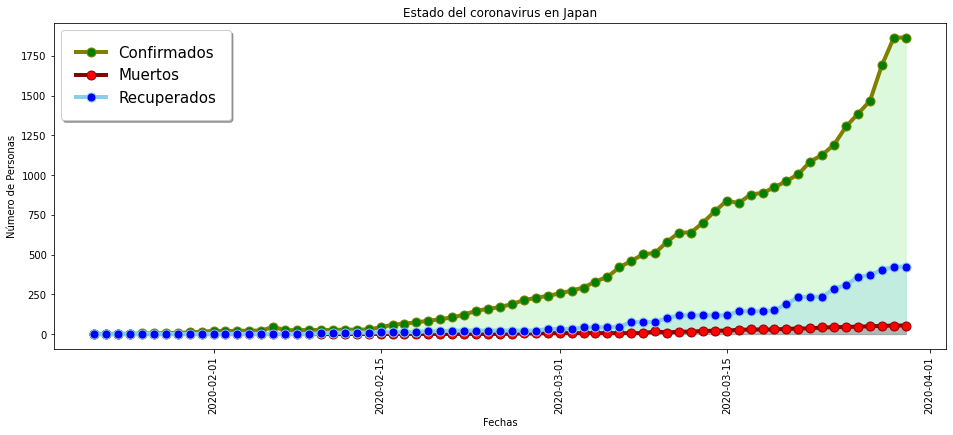

In [0]:
Estado('Japan')

# Comparación entre países

Una manera importante de saber qué tanto ha afectado el Coronavirus a los países es hacer la comparación entre los países más afectados desde el primer día de su aparición. 

En este caso se analizará el comportamiento de los ***n*** primeros países con mayor cantidad de casos Confirmados, Muertos y Recuperados por el Covid-19.

Para esto, la función *Grafica_Comparacion_Top* nos arrojará una gráfica del comportamiento de los casos que se deseen ser comparados y mostrados, siendo así, la función recibe los parámetros de la situación a analizar, ya sea **Confirmados, Muertos o Recuperados** y un número **n** de los n primeros países con mayor casos según la situación.

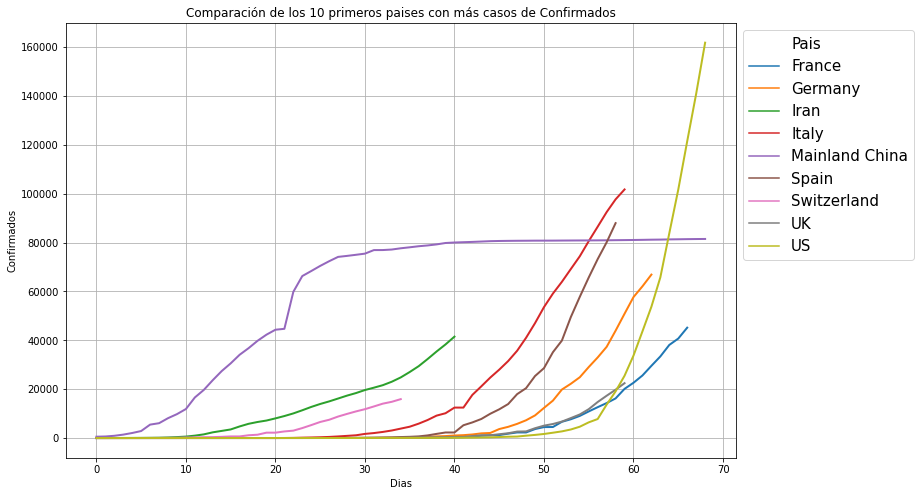

In [0]:
Grafica_Comparacion_Top('Confirmados',10)

# Predicción de los casos

Una herramienta muy útil al momento de tomar una desición respecto al Coronavirus es su proyección en un futuro cercano. Este proyecto implementa la predicción de series de tiempo con la ayuda de **Prophet**, es un proyecto de código abierto desarrollado por Facebook con el fin de predecir series de tiempo. Las ventajas de Prophet son la predicción a un cierto periodo de tiempo con una presición muy adecuada, además de contar con un rápido entreno del modelo. 

La función *Prediccion_Casos* tiene como fin mostrar los datos proyectados a un futuro cercano, ya sea la predicción de los casos de **Confirmados, Muertos o Recuperados** en cierto país o el mundo entero.

Los resultados obtenidos por la función serán una tabla que muestra a los próximos días los resultados predichos (yhat), incluyendo un mínimo (yhat_lower) y un máximo (yhat_upper) de valores proyectados, además de la representación gráfica del comportamiento que describe **Prophet** sobre los datos tenidos a través del tiempo y de cómo se mantendría a un futuro.



,ds,yhat,yhat_lower,yhat_upper
67,2020-03-29,140888.859780,140067.042004,141693.420752
68,2020-03-30,162206.522345,161422.502802,163030.895718
69,2020-03-31,183703.573782,182863.508135,184516.995738
70,2020-04-01,204488.788354,203714.411537,205281.806422
71,2020-04-02,224521.933134,223709.546006,225358.520655


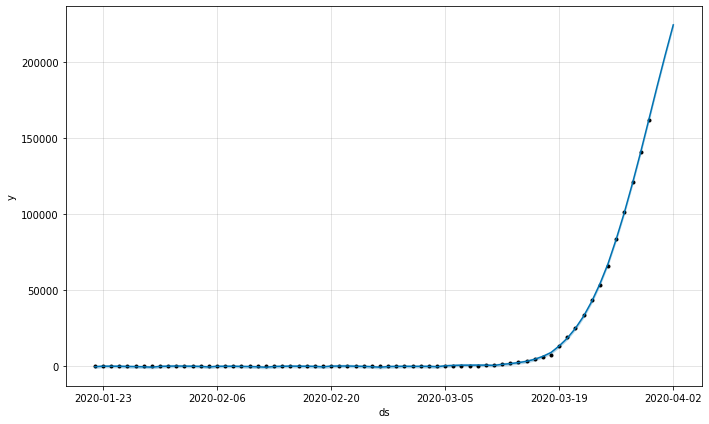

In [57]:
Prediccion_Casos("Confirmados", 'US')

# Funciones en concreto

La función ***Estado*** dependiendo de la localización, ya sea el Mundo o un País en específico realiza cada uno cierta función con una ligera diferencia, facilmente reconocible en el código.

En primer lugar, la función *Estado* toma la fecha actual o del último día que se tenga registro, teniendo así a todos los países mostrando los datos de cada situación, como lo son confirmados, muertos y recuperados al día actual, es decir, el acumulado que se tienen. Finalmente se realiza la suma total de estos según la situación y este cálculo es el valor que se imprime.

Al final se incluye una gráfica que nos muestra la cantidad de datos recogidos por cada fecha, teniendo así la cantidad de datos por cada situación que muestra el crecimiento a través del tiempo

In [0]:
def Estado(Lugar):
    if(Lugar=='Mundo'):
        actualizado = df[df.Fecha == df.Fecha.max()]
        Total_Confirmados = np.sum(actualizado['Confirmados'])
        Total_Recuperados = np.sum(actualizado['Recuperados'])
        Total_Muertos = np.sum(actualizado['Muertos'])
        Tasa_Mortalidad = np.sum(actualizado['Muertos'])/np.sum(actualizado['Confirmados'])*100    
   
        print ('Total casos confirmados: %.d' % Total_Confirmados)
        print ('Total muertes: %.d' % Total_Muertos)
        print ('Total recuperados: %.d' %  Total_Recuperados)
        print ('Tasa de Mortalidad %%: %.3f' % Tasa_Mortalidad)
        
        Grafica_Mundo()
        
    elif((df['Pais'].unique())==(str(Lugar))).any():
        Pais = df[df["Pais"]==Lugar]
        actualizado = Pais[Pais.Fecha == df.Fecha.max()]
        Confirmados = np.sum(actualizado['Confirmados'])
        Recuperados = np.sum(actualizado['Recuperados'])
        Muertos = np.sum(actualizado['Muertos'])
        Tasa_Mortalidad = np.sum(actualizado['Muertos'])/np.sum(actualizado['Confirmados'])*100
        
        print ('Total casos confirmados: %.d' % Confirmados)
        print ('Total muertes: %.d' % Muertos)
        print ('Total recuperados: %.d' %  Recuperados  )   
        print ('Tasa de Mortalidad %%: %.3f' % Tasa_Mortalidad)
        
        
        Graf_Lugar(Lugar)
            
    else:
        print("El país ingresado no existe o no está registrado")
        

def Graf_Lugar(Lugar):       
    plt.figure(figsize=(16, 6))
    plt.xticks(rotation=90)

    Pais = df[df["Pais"]==Lugar].groupby("Fecha")[['Confirmados', 'Muertos', 'Recuperados']].sum().reset_index()

    plt.fill_between(Pais["Fecha"], Pais["Confirmados"], color="lightgreen", alpha=0.3)
    plt.fill_between(Pais["Fecha"], Pais["Muertos"], color="darkred", alpha=0.3)
    plt.fill_between(Pais["Fecha"], Pais["Recuperados"], color="skyblue", alpha=0.3)


    plt.plot("Fecha","Confirmados", data=Pais, linestyle='-',label='Confirmados', marker='o',markerfacecolor='green', markersize=9, color='olive', linewidth=4)
    plt.plot("Fecha","Muertos", data=Pais, linestyle='-', label='Muertos',marker='o',markerfacecolor='red', markersize=9, color='darkred', linewidth=4)
    plt.plot("Fecha","Recuperados", data=Pais, linestyle='-',label='Recuperados', marker='o',markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4)


    plt.title('Estado del coronavirus en '+str(Lugar))
    plt.xlabel('Fechas')
    plt.ylabel('Número de Personas')
    plt.legend(loc='best',fancybox=True,fontsize=15,framealpha=1, shadow=True, borderpad=1)

    plt.show()


def Grafica_Mundo():

    Confirmados = df.groupby('Fecha').sum()['Confirmados'].reset_index()
    Muertos = df.groupby('Fecha').sum()['Muertos'].reset_index()
    Recuperados = df.groupby('Fecha').sum()['Recuperados'].reset_index()

    plt.figure(figsize=(16, 6))
    plt.xticks(rotation=90)

    plt.fill_between(Confirmados["Fecha"], Confirmados["Confirmados"], color="lightgreen", alpha=0.3)
    plt.fill_between(Muertos["Fecha"], Muertos["Muertos"], color="darkred", alpha=0.3)
    plt.fill_between(Recuperados["Fecha"], Recuperados["Recuperados"], color="skyblue", alpha=0.3)


    plt.plot("Fecha","Confirmados", data=Confirmados, linestyle='-',label='Confirmados', marker='o',markerfacecolor='green', markersize=9, color='olive', linewidth=4)
    plt.plot("Fecha","Muertos", data=Muertos, linestyle='-', label='Muertos',marker='o',markerfacecolor='red', markersize=9, color='darkred', linewidth=4)
    plt.plot("Fecha","Recuperados", data=Recuperados, linestyle='-',label='Recuperados', marker='o',markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4)


    plt.title('Reporte a nivel mundial del Coronavirus')
    plt.xlabel('Fechas')
    plt.ylabel('Número de Personas')
    plt.legend(loc='best',fancybox=True,fontsize=15, framealpha=1, shadow=True, borderpad=1)

    plt.show()



Prophet sigue el modelo API de sklearn al crear una instancia como entrenar y predecir valores futuros

La predicción que realiza Prophet es muy precisa, pero requiere unas entradas muy específicas.

* Requiere de dos columnas específicamente nombradas 'ds' y 'y', donde:    

    - 'ds' es datestamp o la marca de tiempo que debe ser ingresada en el formato de datatime de pandas, como lo es YYYY-MM-DD or YYYY-MM-DD HH:MM:SS  
    
    - 'y' es la columna numérica que queremos predecir.

Además, prophet cuenta con la gráfica donde muestra los datos a través del tiempo y el ajuste que realiza en descripción de este comportamiento 
    

In [0]:
def Prediccion_Casos(Situacion, Lugar):
    
    if(Lugar=='Mundo'):
        if(Situacion=='Confirmados'):
            Confirmados = df.groupby('Fecha').sum()['Confirmados'].reset_index()
            Confirmados.columns = ['ds','y']
            return Pred(Confirmados)
        
        elif(Situacion=='Muertos'):
            Muertos = df.groupby('Fecha').sum()['Muertos'].reset_index()
            Muertos.columns = ['ds','y']
            return Pred(Muertos)
        
        elif(Situacion=='Recuperados'):
            Recuperados = df.groupby('Fecha').sum()['Recuperados'].reset_index()   
            Recuperados.columns = ['ds','y']
            return Pred(Recuperados)
    
    elif((df['Pais'].unique())==(str(Lugar))).any():        
        Pais = df[df["Pais"]==Lugar]
        if((Situacion)=='Confirmados'):
            Pais_Confirmados = Pais.groupby('Fecha').sum()['Confirmados'].reset_index()
            Pais_Confirmados.columns = ['ds','y']
            return Pred(Pais_Confirmados)
        
        elif((Situacion)=='Muertos'):
            Pais_Muertos = Pais.groupby('Fecha').sum()['Muertos'].reset_index()
            Pais_Muertos.columns = ['ds','y']
            return Pred(Pais_Muertos)
        
        elif((Situacion)=='Recuperados'):
            Pais_Recuperados = Pais.groupby('Fecha').sum()['Recuperados'].reset_index()
            Pais_Recuperados.columns = ['ds','y']
            return Pred(Pais_Recuperados)
            
    else:
        print("El país ingresado no existe o no está registrado")

def Pred(Ubicacion):
    Ubicacion.columns = ['ds','y']
    P = Prophet(interval_width=0.95)
    P.daily_seasonality=True
    P.yearly_seasonality=True 
    P.fit(Ubicacion)
    Futuro = P.make_future_dataframe(periods=3)
    Prediccion = P.predict(Futuro)
    P.plot(Prediccion)    
    return Prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



La función *Grafica_Comparacion_Top* se encarga de poner en una misma gráfica el comportamiento de los primeros *n* países según la cantidad de casos que contengan para cada *Situacion*.

En primer lugar, la función crea una copia del dataset original, y le agrega un par de columnas llamadas ***Primera_FechaxPais*** y ***Dias***, las cuales se llenan con la fecha en que se registró el primero caso de Covid-19 en cada país y calcula el número de de días que han transcurrido desde entonces.

***Pais_Dias*** Organiza el dataset copiado con las nuevas columnas anteriormente mencionadas, y organiza de tal forma que cada país muestre la cantidad de Confirmados, Muertos y Recuperados que hubo cada día.

Para crear el top *n* de casos para cada *Situacion*, la función organiza según la cantidad de casos que hayan para cada Situación y los guarda en una lista, teniendo así que ***Confirmados_Top*** lo conforman los *n* primeros países con más casos de confirmados.

Finalmente para graficar estos n casos, se pasan a la función *Grafica* pasandole como parámetros la lista con los *n* primeros países, la situación y el *n*.

La función *Grafica* recibe estos parámetros, y en ***Top_Paises*** guarda todos los paises que se encuentren en la lista ***Confirmados_Top*** y así procede a graficarlos todos juntos.



In [0]:
def Grafica_Comparacion_Top(Situacion,n):
    
    
    a=df.copy()
    a['Primera_FechaxPais'] = a.groupby('Pais')['Fecha'].transform('min')
    a['Dias'] = (a['Fecha'] - a['Primera_FechaxPais']).dt.days
    
    Ultima_Fecha = df[df.Fecha == df.Fecha.max()]
    
    Pais_Dias = a.groupby(['Pais','Dias'])[['Confirmados','Muertos','Recuperados']].sum().reset_index()
    
    
    if(Situacion=='Confirmados'):
        Confirmados_Top = Ultima_Fecha.sort_values('Confirmados', ascending=False).head(n)['Pais'].to_list()
        Grafica(Confirmados_Top,Situacion,n,Pais_Dias)
        
    elif(Situacion=='Recuperados'):
        Recuperados_Top= Ultima_Fecha.sort_values('Recuperados', ascending=False).head(n)['Pais'].to_list()
        Grafica(Recuperados_Top,Situacion,n,Pais_Dias)
        
    elif(Situacion=='Muertos'):
        Muertos_Top = Ultima_Fecha.sort_values('Muertos', ascending=False).head(n)['Pais'].to_list()
        Grafica(Muertos_Top,Situacion,n,Pais_Dias)
    
def Grafica(Situacion_Top, Situacion,n,Pais_Dias):
    Top_Paises = Pais_Dias[Pais_Dias.Pais.isin(Situacion_Top)]
    plt.figure(figsize=(12,8))
    sns.lineplot(x='Dias',y=Situacion, data=Top_Paises, hue='Pais', lw=2)
    plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
    plt.grid(True)
    plt.title('Comparación de los '+ str(n) + ' primeros paises con más casos de ' + str(Situacion))
    plt.show()

